In [1]:
import sys
import os
sys.path.append(os.getcwd())

import random
import cv2
from config import Config
import json

config_file = 'resnet34_512_02_02.json'
image_suffix = 'mini_fold0_'
datasets = os.path.join('/', 'opt', 'datasets', 'train')
with open(config_file, 'r') as f:
    cfg = json.load(f)

config=Config(**cfg)

target_path = os.path.join('/','results', config.folder+'_test')
val_path = os.path.join(datasets, 'masks2m')
img_path = os.path.join(datasets, 'images')
target = os.listdir(os.path.join('/results', config.folder)+'_test')
print('count of target images: ', len(target))
val = os.listdir(os.path.join(datasets, 'masks2m'))
print('count of val images: ', len(val))

count of target images:  20496
count of val images:  20496


In [2]:
def calculate_iou(image1, image2):
    intersection = cv2.bitwise_and(image1, image2)
    union = cv2.bitwise_or(image1, image2)
    iou_score = cv2.countNonZero(intersection) / cv2.countNonZero(union)
    return iou_score

def iou(box1, box2):
    xi1 = max(box1[1], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[1], box2[2])
    inter_area =(yi2 - yi1) * (xi2 - xi1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] * box1[1])   
    box2_area = (box2[2] - box2[0]) * (box2[3] * box2[1])
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    
    return iou

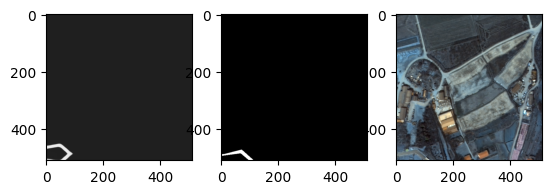

In [3]:
i = random.randint(0, len(target))

import matplotlib.pyplot as plt
target_image = cv2.imread(os.path.join(target_path, target[i]))
val_image = cv2.imread(os.path.join(val_path, target[i][6:]))
origin_image = cv2.imread(os.path.join(img_path, target[i][6:]))

fig, ax = plt.subplots(1, 3)
# for j in range(3):
#     ax[j].axis('off')
ax[0].imshow(target_image)
ax[1].imshow(val_image)
ax[2].imshow(origin_image)

In [4]:
resized_target_image = cv2.resize(target_image, (512, 512))
print("Target image shape:", target_image.shape)
print("Val image shape:", val_image.shape)
print("Origin image shape:", origin_image.shape)

Target image shape: (512, 512, 3)
Val image shape: (512, 512, 3)
Origin image shape: (512, 512, 3)


In [5]:
target_mask = cv2.cvtColor(resized_target_image, cv2.COLOR_BGR2GRAY)
val_mask = cv2.cvtColor(val_image, cv2.COLOR_BGR2GRAY)

In [6]:
def binarize_image(image, threshold): # grayscale -> 이진화
    # Grayscale 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이진화
    _, binary_image = cv2.threshold(gray_image, threshold, 1, cv2.THRESH_BINARY)

    return binary_image

In [7]:
threshold = 128

target_binary = binarize_image(resized_target_image, threshold)
val_binary = binarize_image(val_image, threshold)

In [8]:
import numpy as np

def zhang_suen_thinning(image):
    def neighbors(x, y, image):
        """Return 8-neighbors of pixel (x, y) in the image."""
        shape = image.shape
        neighbors = []
        if x > 0:
            neighbors.append(image[x - 1, y])
            if y > 0:
                neighbors.append(image[x - 1, y - 1])
            if y < shape[1] - 1:
                neighbors.append(image[x - 1, y + 1])
        if x < shape[0] - 1:
            neighbors.append(image[x + 1, y])
            if y > 0:
                neighbors.append(image[x + 1, y - 1])
            if y < shape[1] - 1:
                neighbors.append(image[x + 1, y + 1])
        if y > 0:
            neighbors.append(image[x, y - 1])
        if y < shape[1] - 1:
            neighbors.append(image[x, y + 1])
        return neighbors

    def transitions(neighbors):
        """Return the number of 0 to 1 transitions in the binary sequence of neighbors."""
        n = len(neighbors)
        return sum((neighbors[i % n] == 0 and neighbors[(i + 1) % n] == 1) for i in range(n))

    def thinning_iteration(image):
        markers = np.zeros_like(image, dtype=np.uint8)
        to_delete = []

        for x in range(1, image.shape[0] - 1):
            for y in range(1, image.shape[1] - 1):
                if image[x, y] == 0:
                    continue

                nb = neighbors(x, y, image)
                transitions_count = transitions(nb)

                if 2 <= transitions_count <= 6:
                    markers[x, y] = 1

                    # Conditions for pixel deletion
                    if (nb[0] * nb[2] * nb[4] == 0 and
                        nb[2] * nb[4] * nb[6] == 0):
                        to_delete.append((x, y))

        for x, y in to_delete:
            image[x, y] = 0

        return markers

    # Convert image to binary (0 or 1)
    binary_image = (image > 0).astype(np.uint8)

    # Perform thinning iterations until no more pixels can be deleted
    prev_image = np.zeros_like(binary_image)
    while not np.array_equal(prev_image, binary_image):
        prev_image = binary_image.copy()
        markers = thinning_iteration(binary_image)
        binary_image &= ~markers

    return binary_image.astype(np.uint8) * 255

In [9]:
skeleton = zhang_suen_thinning(target_binary)

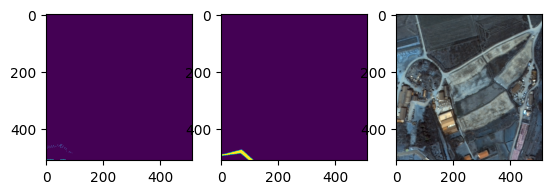

In [10]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(skeleton)
ax[1].imshow(val_binary)
ax[2].imshow(origin_image)

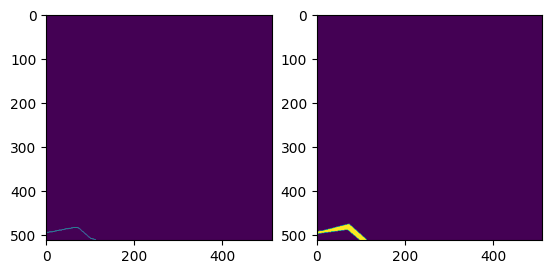

In [11]:
from skimage.morphology import skeletonize

image = val_binary
skeleton = skeletonize(image)

fig, ax = plt.subplots(1,2)
ax[0].imshow(skeleton)
ax[1].imshow(image)

In [12]:
def calculate_iou(binary_image1, binary_image2):
    tp = fp = fn = 0

    height, width = binary_image1.shape

    for i in range(height):
        for j in range(width):
            if binary_image1[i, j] == 1 and binary_image2[i, j] == 1:
                tp += 1
            elif binary_image1[i, j] == 1 and binary_image2[i, j] == 0:
                fp += 1
            elif binary_image1[i, j] == 0 and binary_image2[i, j] == 1:
                fn += 1

    iou = tp / (tp + fp + fn)
    return iou

In [13]:
iou_score = calculate_iou(target_binary, val_binary)
print("IoU Score:", iou_score)

IoU Score: 0.11904761904761904


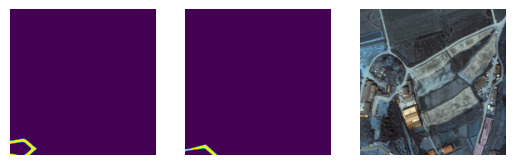

In [14]:
fig, ax = plt.subplots(1, 3)
for j in range(3):
    ax[j].axis('off')
ax[0].imshow(target_binary)
ax[1].imshow(val_binary)
ax[2].imshow(origin_image)

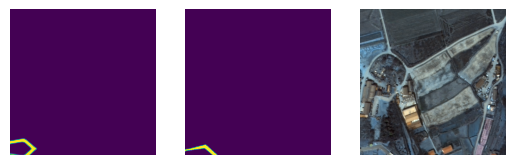

In [15]:
fig, ax = plt.subplots(1, 3)
for j in range(3):
    ax[j].axis('off')
ax[0].imshow(target_mask)
ax[1].imshow(val_mask)
ax[2].imshow(origin_image)

In [16]:
print(target_image.shape, val_image.shape, origin_image.shape)

(512, 512, 3) (512, 512, 3) (512, 512, 3)


(536, 536, 3)


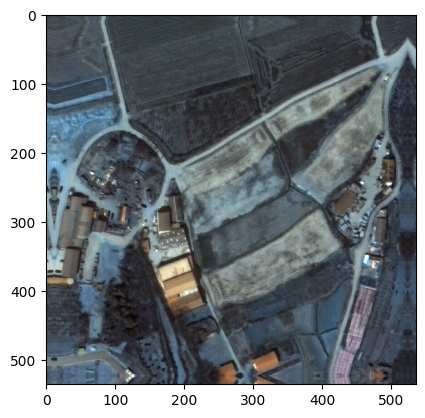

In [17]:
c = cv2.copyMakeBorder(origin_image, 12,12,12,12, cv2.BORDER_REFLECT)
fig, ax = plt.subplots(1,1)
ax.imshow(c)
print(c.shape)